# Report Generation

In [32]:
# run in base directory
WORKDIR = "/home/awesome"
import os
os.chdir(WORKDIR)

# datatypes
import json
import yaml
from datetime import datetime
# database connection
import psycopg2
import psycopg2.extras
import psycopg2.extensions as psql_ext
from psycopg2 import sql
# computation
import pandas as pd
import numpy as np
# utilities
from pathlib import Path
import itertools
# typing
from typing import Union
# visualization
import plotly.graph_objs as go
from plotly.subplots import make_subplots

PROJECT_SCHEMA = 'citibike_project'

WORKDIR_PATH = Path.cwd()
REPORTING_PATH = WORKDIR_PATH / 'reporting'

In [5]:
# PSQL db connection using psycopg2
conn = psycopg2.connect(
    dbname='new_db', 
    user='awesome_user', 
    password='awesome_password', 
    host='postgres', 
    port='5432'
)

## Assemble Visuals

### Vis 1: Historic rides, precip by day

In [9]:
query_rides_by_day = f"""
    WITH

    rides AS (
        SELECT
            MAKE_DATE(sh.year, sh.month, sh.day) AS dt,
            SUM(num_inbound) AS n_rides
        FROM
            {PROJECT_SCHEMA}.citibike_station_history sh
        WHERE
            MAKE_DATE(sh.year, sh.month, sh.day) >= '2023-06-01'
        GROUP BY 1
    ),

    temp AS (
        SELECT
            w.date AS dt,
            MAX(temperature_f) AS daily_high
        FROM
            {PROJECT_SCHEMA}.weather_general w
        GROUP BY 1
    ),

    precip AS (
        SELECT
            wp.date AS dt,
            SUM(
                CAST(
                    CASE WHEN wp.one_hour_precip_amount = 'T' THEN '0.0' ELSE wp.one_hour_precip_amount END
                AS FLOAT)
            ) AS precip_amount
        FROM
            {PROJECT_SCHEMA}.weather_precip wp
        GROUP BY 1
    )

    SELECT
        r.*,
        t.daily_high,
        p.precip_amount
    FROM
        rides r

        LEFT JOIN temp t
            ON r.dt = t.dt
        
        LEFT JOIN precip p
            ON r.dt = p.dt
"""

df_rides_by_day = pd.read_sql_query(query_rides_by_day, conn)
df_rides_by_day["dt"] = pd.to_datetime(df_rides_by_day["dt"])

/tmp/ipykernel_56/2967334811.py:51: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_rides_by_day = pd.read_sql_query(query_rides_by_day, conn)


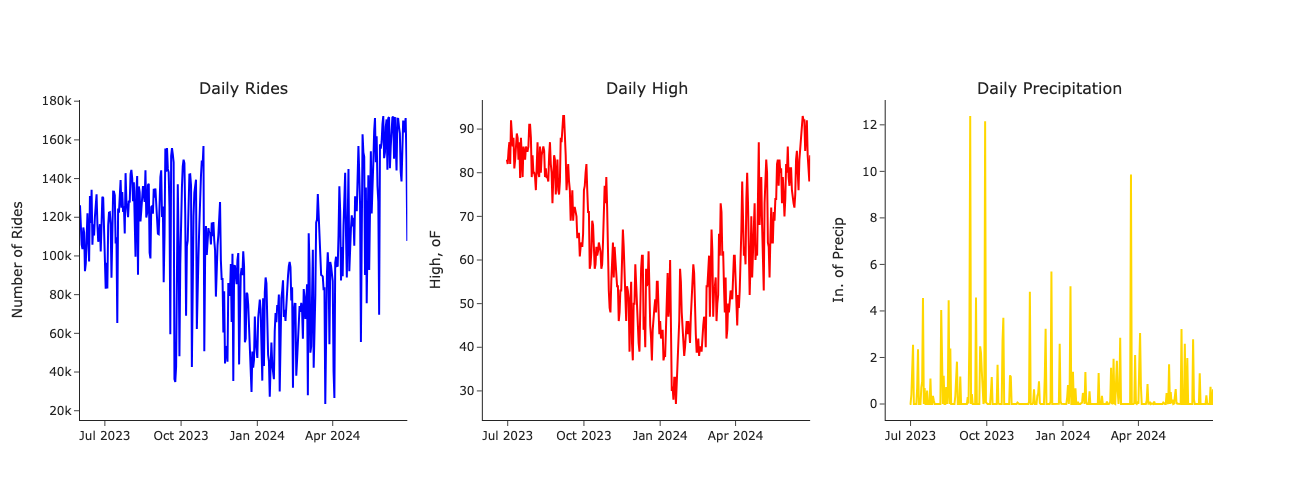

In [30]:
fig_rides_weather_ts = make_subplots(
    rows=1,
    cols=3,
    subplot_titles = ["Daily Rides", "Daily High", "Daily Precipitation"],
)

# FIG 1: Rides 
fig_rides_weather_ts.add_trace(
    go.Scatter(
        x=df_rides_by_day['dt'],
        y=df_rides_by_day['n_rides'],
        marker={"color":"blue"},
        mode="lines",
        showlegend=False,
    ),
    row=1, col=1
)

# FIG 2: Temperature
fig_rides_weather_ts.add_trace(
    go.Scatter(
        x=df_rides_by_day['dt'],
        y=df_rides_by_day['daily_high'],
        marker={"color":"red"},
        mode="lines",
        showlegend=False,
    ),
    row=1, col=2
)

# FIG 3: Precipitation
fig_rides_weather_ts.add_trace(
    go.Scatter(
        x=df_rides_by_day['dt'],
        y=df_rides_by_day['precip_amount'],
        marker={"color":"gold"},
        mode="lines",
        showlegend=False,
    ),
    row=1, col=3
)

for col, y_label in enumerate([
    "Number of Rides",
    "High, oF",
    "In. of Precip",
]):
    axis_title_key = f'yaxis{col+1}_title'
    fig_rides_weather_ts.update_layout(**{axis_title_key: y_label})

fig_rides_weather_ts.update_layout(
    width=1200, height=500,
    template="simple_white"
)

fig_rides_weather_ts.show()

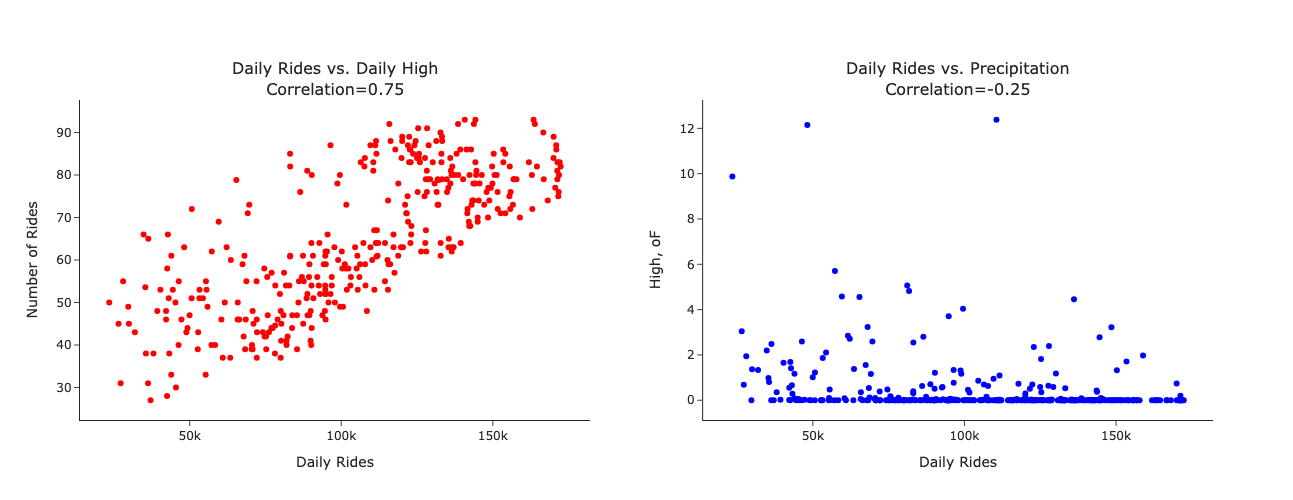

In [46]:
correls = [
    df_rides_by_day[[field, "n_rides"]].dropna().corr().values[0, 1] for field in ['daily_high', 'precip_amount']
]

fig_rides_weather_relationship = make_subplots(
    rows=1,
    cols=2,
    subplot_titles = [
        f"Daily Rides vs. Daily High<br>Correlation={correls[0]:,.2f}",
        f"Daily Rides vs. Precipitation<br>Correlation={correls[1]:,.2f}"
    ],
)

# FIG 1: Temperature 
fig_rides_weather_relationship.add_trace(
    go.Scatter(
        x=df_rides_by_day['n_rides'],
        y=df_rides_by_day['daily_high'],
        marker={"color":"red"},
        mode="markers",
        showlegend=False,
    ),
    row=1, col=1
)

# FIG 2: Temperature
fig_rides_weather_relationship.add_trace(
    go.Scatter(
        x=df_rides_by_day['n_rides'],
        y=df_rides_by_day['precip_amount'],
        marker={"color":"blue"},
        mode="markers",
        showlegend=False,
    ),
    row=1, col=2
)

for col, y_label in enumerate([
    "Number of Rides",
    "High, oF",
]):
    axis_title_key = f'xaxis{col+1}_title'
    fig_rides_weather_relationship.update_layout(**{axis_title_key: "Daily Rides"})
    axis_title_key = f'yaxis{col+1}_title'
    fig_rides_weather_relationship.update_layout(**{axis_title_key: y_label})

fig_rides_weather_relationship.update_layout(
    width=800, height=500,
    template="simple_white"
)

fig_rides_weather_relationship.show()

# Vis 2: Income vs. Stations

In [67]:
query_zip_codes = f"""
    WITH

    zip_codes AS (
        SELECT
            zipcode AS zip_code,
            SUM(N1 * A00100) / SUM(N1) AS avg_agi,
            SUM(N1) AS total_returns
        FROM
            {PROJECT_SCHEMA}.nyc_irs
        GROUP BY 1
    ),

    stations AS (
        SELECT
            zip_code,
            SUM(capacity) AS station_capacity
        FROM
            {PROJECT_SCHEMA}.station_info
        GROUP BY 1
    )
    
    SELECT
        z.*,
        CASE WHEN s.station_capacity IS NULL THEN 0 ELSE s.station_capacity END AS station_capacity
    FROM
        zip_codes z

        LEFT JOIN stations s
            ON z.zip_code = s.zip_code

"""

df_zip_codes = pd.read_sql_query(query_zip_codes, conn)
df_zip_codes.head()

/tmp/ipykernel_56/1765591348.py:34: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



,zip_code,avg_agi,total_returns,station_capacity
0,11203,3.092567e+05,35790.0,742
1,10016,1.835187e+06,30730.0,1264
2,11415,1.070647e+05,9420.0,0
3,11422,1.536270e+05,16260.0,0
4,11412,1.736360e+05,19360.0,0


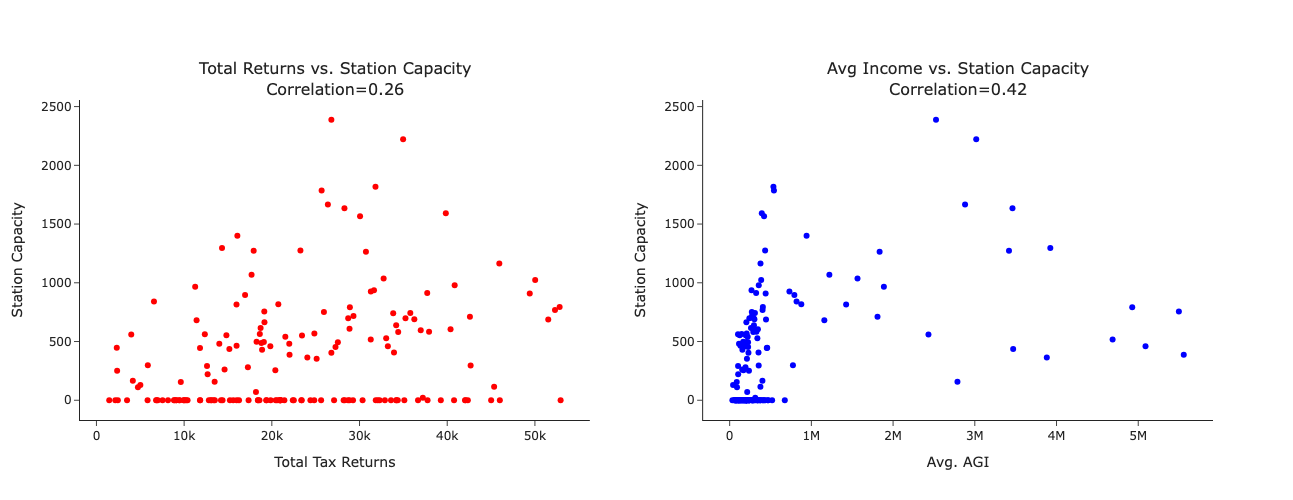

In [69]:
correls = [
    df_zip_codes[[field, "station_capacity"]].dropna().corr().values[0, 1] for field in ['total_returns', 'avg_agi']
]

fig_zip_codes = make_subplots(
    rows=1,
    cols=2,
    subplot_titles = [
        f"Total Returns vs. Station Capacity<br>Correlation={correls[0]:,.2f}",
        f"Avg Income vs. Station Capacity<br>Correlation={correls[1]:,.2f}"
    ],
)

for i, x_col in enumerate(['total_returns', 'avg_agi']):
    fig_zip_codes.add_trace(
        go.Scatter(
            x=df_zip_codes[x_col],
            y=df_zip_codes['station_capacity'],
            marker={"color":["red", "blue"][i]},
            mode="markers",
            showlegend=False,
        ),
        row=1, col=i+1
    )

for col, x_label in enumerate([
    "Total Tax Returns",
    "Avg. AGI",
]):
    axis_title_key = f'xaxis{col+1}_title'
    fig_zip_codes.update_layout(**{axis_title_key: x_label})
    axis_title_key = f'yaxis{col+1}_title'
    fig_zip_codes.update_layout(**{axis_title_key: "Station Capacity"})

fig_zip_codes.update_layout(
    width=800, height=500,
    template="simple_white"
)

fig_zip_codes.show()

## Finalize Report

In [71]:
# Convert figures to HTML strings
figs = {
    fig_name:fig.to_html(full_html=False, include_plotlyjs='cdn')
    for fig_name, fig in [
        ('rides_weather_ts', fig_rides_weather_ts),
        ('rides_weather_relationship', fig_rides_weather_relationship),
        ('capacity_irs_data', fig_zip_codes),
    ]
}

# Create the HTML template
template = f"""
<html>
<head>
    <title>Plotly Report</title>
    <script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
</head>
<body>
    <h1>CitiBike Report</h1>
    <div id='divPlotly1'>
        <h2>Rides vs. Weather Over Time</h2>
        {figs['rides_weather_ts']}
    </div>
    <div id='divPlotly2'>
        <h2>Rides vs. Weather Over Relationship</h2>
        {figs['rides_weather_relationship']}
    </div>
    <div id='divPlotly3'>
        <h2>Station Capacity vs. IRS Data</h2>
        {figs['capacity_irs_data']}
    </div>
</body>
</html>
"""

# Write the HTML report to a file
with open(REPORTING_PATH / 'reports' / 'report.html', 'w') as f:
    f.write(template)
